In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv('data/train.txt', sep='\t', names=['winner', 'r_1', 'r_2', 'd_1', 'd_2'], na_values=-1)

print(df.shape)
df.head(3)

(1000, 5)


,winner,r_1,r_2,d_1,d_2
0,0.5,8.154642,NaN,0.000552,0.000483
1,1.0,NaN,9.105132,0.075709,0.024765
2,0.0,7.349630,NaN,0.045557,0.006901


**Handling missing data**

In [28]:
df.isna().sum()

winner      0
r_1       408
r_2       438
d_1         0
d_2         0
dtype: int64

In [29]:
df.fillna(np.nanmean(df[['r_1', 'r_2']]), inplace=True)

df.head(3)

,winner,r_1,r_2,d_1,d_2
0,0.5,8.154642,7.945215,0.000552,0.000483
1,1.0,7.945215,9.105132,0.075709,0.024765
2,0.0,7.349630,7.945215,0.045557,0.006901


**Taking a look at the distributions**

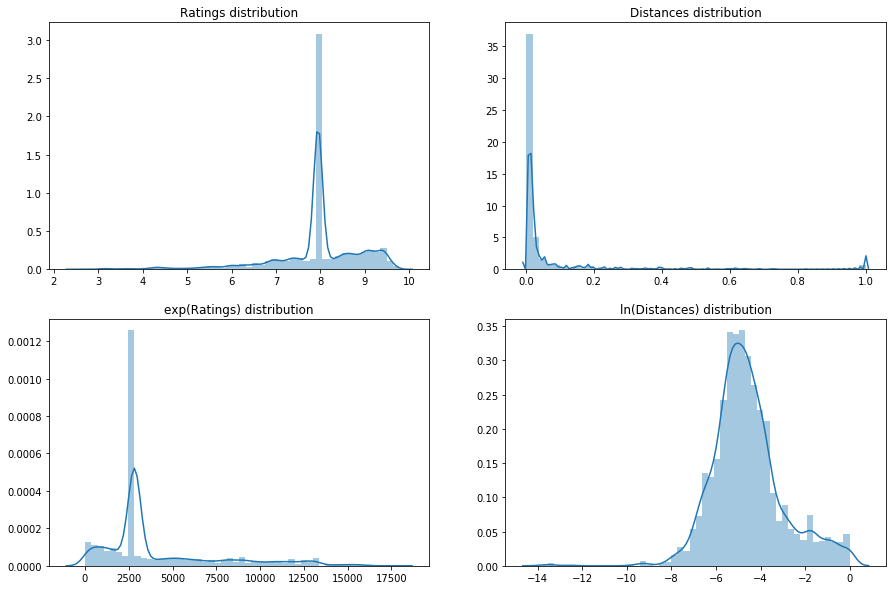

In [95]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Ratings distribution')
sns.distplot(pd.concat([df['r_1'], df['r_2']]))

plt.subplot(222)
plt.title('Distances distribution')
sns.distplot(pd.concat([df['d_1'], df['d_2']]));

plt.subplot(223)
plt.title('exp(Ratings) distribution')
sns.distplot(np.exp(pd.concat([df['r_1'], df['r_2']])))

plt.subplot(224)
plt.title('ln(Distances) distribution')
sns.distplot(np.log(pd.concat([df['d_1'], df['d_2']]) + 1e-6));

**Preparing data for model training**

In [22]:
df.winner.value_counts()

0.0    469
1.0    407
0.5    124
Name: winner, dtype: int64

In [105]:
X = df[df.winner != 0.5]
X.winner = X.winner.replace(0, -1)
X[['d_1', 'd_2']] = np.log(X[['d_1', 'd_2']] + 1e-6)
X[['r_1', 'r_2']] = np.exp(X[['r_1', 'r_2']])

r_mean, r_std = X[['r_1', 'r_2']].values.flatten().mean(), X[['r_1', 'r_2']].values.flatten().std()
X[['r_1', 'r_2']] = (X[['r_1', 'r_2']] - r_mean) / r_std

X.head(3)

,winner,r_1,r_2,d_1,d_2
1,1.0,-0.383383,1.404541,-2.580847,-3.698273
2,-1.0,-0.749808,-0.383383,-3.088770,-4.975992
3,-1.0,-0.857107,-0.383383,-7.902383,-5.500641


$$ \hat{y} = \sigma(score_{winner} - score_{looser}) \rightarrow \max_{w} $$

In [107]:
def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def Loss(X, w):
    score_1 = (X[['r_1', 'd_1']] * w).sum(axis=1)
    score_2 = (X[['r_2', 'd_2']] * w).sum(axis=1)
    x = X.winner * (score_2 - score_1)
    
    return - np.log(Sigmoid(x)).mean()

Loss(X, [1, 1])

0.9283048500686658

In [108]:
def Grad(X, w):
    score_1 = (X[['r_1', 'd_1']] * w).sum(axis=1)
    score_2 = (X[['r_2', 'd_2']] * w).sum(axis=1)
    x = X.winner * (score_2 - score_1)
    s = Sigmoid(x)
    
    dw1 = - ((1 - s) * X.winner * (X.r_2 - X.r_1)).mean()
    dw2 = - ((1 - s) * X.winner * (X.d_2 - X.d_1)).mean()
    
    return np.array([dw1, dw2])

Grad(X, [1, 1])

array([0.06710244, 0.32802939])

In [109]:
n_iter = 100
learning_rate = 0.1
w = np.array([1, 1], float)

losses = []
for i in range(n_iter):
    
    loss = Loss(X, w)
    losses.append(loss)
    if (i + 1) % 10 == 0:
        print(f'Iteration {i + 1}. Loss: {loss}')
    
    grad = Grad(X, w)
    w -= learning_rate * grad
    
print(f'w = {w}')

Iteration 10. Loss: 0.8354575298219432
Iteration 20. Loss: 0.7526987696298029
Iteration 30. Loss: 0.6915959509216452
Iteration 40. Loss: 0.6505160437851331
Iteration 50. Loss: 0.6240834402808121
Iteration 60. Loss: 0.6066464250774514
Iteration 70. Loss: 0.5946927560864497
Iteration 80. Loss: 0.5862527651921239
Iteration 90. Loss: 0.5801502888664244
Iteration 100. Loss: 0.5756442392170578
w = [ 0.64890845 -0.64049816]


In [106]:
r_mean, r_std

(4147.068486370935, 3456.1486835368005)